<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:0rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2024 @ Author</i></b><br/>
        <i>Author：
            <b>
            <a href="mailto:your_address@email.com">王江海 📨 </a>
            </b>
        </i>
        <br/>
        <i>Date：2024-03-27</i><br/>
        <i>License：</a><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">CC BY-NC-SA 4.0 International</a></i><br/>
</div>

> **算法原理**：
> 
> - [《计算材料学》算法原理](https://nb.bohrium.dp.tech/detail/52743861357)
> - [积分算法代码实现](https://nb.bohrium.dp.tech/detail/49334212168)

## `import`

In [1]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## `class Particle`

In [2]:
class Particle:
    def __init__(self, position, mass, velocity):
        self._mass = mass
        self._velocity = np.array(velocity, dtype=float)
        self._position = np.array(position, dtype=float)

    def __str__(self):
        return f"Particle position: \n{self.position}\nmass: \n{self.mass}\nvelocity: \n{self.velocity}"

    @property
    def mass(self):
        return self._mass

    @mass.setter
    def mass(self, value):
        self._mass = np.array(value)

    @property
    def velocity(self):
        return self._velocity

    @velocity.setter
    def velocity(self, value):
        self._velocity = np.array(value)

    @property
    def position(self):
        return self._position

    @position.setter
    def position(self, value):
        self._position = np.array(value)

## `class Box`

In [3]:
class Box:
    def __init__(self, lower, upper):
        self.lower = np.array(lower,dtype=float)
        self.upper = np.array(upper,dtype=float)
        self.length = self.upper - self.lower

    def __str__(self):
        return f"Box dimension {self.length}"

## `class BoundaryCondition`

In [4]:
class BoundaryCondition:
    """Abstract base class for boundary conditions."""

    def apply(self, particles: List[Particle]) -> None:
        raise NotImplementedError

    def displacement(self, position1: np.ndarray, position2: np.ndarray) -> np.ndarray:
        raise NotImplementedError


class PeriodicBoundaryCondition(BoundaryCondition):
    """Implements periodic boundary conditions."""

    def __init__(self, box: Box):
        self.box = box

    def apply(self, particles: List[Particle]) -> None:
        """
        Applies periodic boundary conditions to all particles in the system.

        Parameters
        ----------
        particles : List[Particle]
            List of all Particle instances in the system.
        box : Box
            The Box instance defining the boundaries of the system.

        Returns
        -------
        None

        Notes
        -----
        This method updates the positions of particles in the system
        such that they adhere to the periodic boundary conditions.
        """
        for p in particles:
            p.position = (p.position - self.box.lower) % self.box.length + self.box.lower

    def displacement(self, position1: np.ndarray, position2: np.ndarray) -> np.ndarray:
        """
        Computes the shortest displacement vector between two positions in a periodic system.

        Parameters
        ----------
        position1 : np.array
            Position of the first particle.
        position2 : np.array
            Position of the second particle.
        box : Box
            The box object representing the system's boundary.

        Returns
        -------
        np.array
            The displacement vector from position2 to position1 taking into account periodic boundary conditions.
        """
        dr = position1 - position2
        dr = dr - np.rint(dr / self.box.length) * self.box.length
        return dr

## `class NeighborList`

In [5]:
class NeighborList:
    """Abstract base class for neighbor list."""

    def build(self):
        raise NotImplementedError

    def update(self) -> None:
        raise NotImplementedError


class VerletList(NeighborList):

    def __init__(self, particles, box, boundary_condition, cutoff, skin_depth):
        self.particles = particles
        self.box = box
        self.boundary_condition = boundary_condition
        self.cutoff = cutoff
        self.skin_depth = skin_depth

    def build(self):
        """Build neighbor list of the particle."""
        self.neighbor_list = []
        self.previous_positions = [p.position for p in self.particles]

        for i, p1 in enumerate(self.particles):
            self.neighbor_list[i] = []
            for p2 in self.particles:
                displacement = self.boundary_condition.displacement(p1.position, p2.position, self.box)
                if p1 != p2 and np.linalg.norm(displacement) < (self.cutoff + self.skin_depth):
                    self.neighbor_list[i].append(p2)

    def update(self):
        max_displacement = max(
            np.linalg.norm(self.boundary_condition.displacement(p.position, self.previous_positions[p], self.box)) for p
            in self.particles)
        if max_displacement > self.skin_depth / 2:
            self.build()

## `class Potential`

In [6]:
class Potential:
    """Abstract base class for potential."""
    def energy_calc(self, particles, start_dist, end_dist):
        raise NotImplementedError

    def force_calc(self, particles, start_dist, end_dist):
        raise NotImplementedError


class LJPotential(Potential):

    def __init__(self, box, pbc, epsilon, sigma, start_dist=3, end_dist=6, cutoff='soft'):
        self.box = box
        self.pbc = pbc
        self.epsilon = epsilon
        self.sigma = sigma
        self.start_dist = start_dist
        self.end_dist = end_dist


        if cutoff not in ['hard', 'soft']:
            raise ValueError('Invalid type of cutoff.')
        else:
            self.cutoff = cutoff

    def _switching_function(self, r, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        # Check the distance against the switching start and cutoff distance
        if r < start_dist:
            return 1.0
        elif r > end_dist:
            return 0.0

        # Compute the normalized distance within the switching interval
        # t = 1 when r = start_dist;  t = 0 when r = end_dist
        t = (end_dist - r) / (end_dist - start_dist)

        # Compute the switching function based on the chosen method

        return 0.5 * (1 - np.cos(np.pi * t))

    def _switching_derivative(self, r, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        if r < start_dist or r > end_dist:
            return 0.0
        else:
            return -0.5 * (np.pi / (end_dist - start_dist)) * np.sin(np.pi * (end_dist - r) / (end_dist - start_dist))

    def _energy_calc(self, r, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        if r <= end_dist:
            if self.cutoff == 'hard':
                V = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
                return V

            if self.cutoff == 'soft':
                V = (self._switching_function(r, start_dist, end_dist) *
                     4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6))
                return V

        else:
            return 0

    def _force_calc(self, r_vec, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        r_magnitude = np.linalg.norm(r_vec)

        if r_magnitude <= end_dist:
            # Compute force without considering cutoff
            force_magnitude = 24 * epsilon * (
                    (2 * (sigma / r_magnitude) ** 12) - (sigma / r_magnitude) ** 6) / r_magnitude

            if self.cutoff == 'soft':
                switching_value = self._switching_function(r_magnitude, start_dist, end_dist)
                switching_derivative = self._switching_derivative(r_magnitude, start_dist, end_dist)
                force_magnitude *= switching_value
                # Add extra force due to derivative of switching function
                force_magnitude -= switching_derivative * 4 * epsilon * (
                        (sigma / r_magnitude) ** 12 - (sigma / r_magnitude) ** 6)
        else:
            force_magnitude = 0.0

        return force_magnitude

    def _force_vector(self, r_vec, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist
        r_magnitude = np.linalg.norm(r_vec)
        force_magnitude = self._force_calc(r_vec, start_dist, end_dist)
        # Add force vector to total force
        net_force = force_magnitude * (r_vec / r_magnitude)

        return net_force

    def Energy(self, particles, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        atom_energy = np.zeros(len(particles))

        for i, p1 in enumerate(particles):
            for p2 in particles:
                if p2 is not p1:
                    r_vec = self.pbc.displacement(p1.position, p2.position)
                    r = np.linalg.norm(r_vec)
                    atom_energy[i] = atom_energy[i] + 0.5 * self._energy_calc(r, start_dist, end_dist)

        energy = np.sum(atom_energy)

        return np.array(energy)

    def Force(self, particles, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        force_vector = np.zeros((len(particles), 3))

        for i, p1 in enumerate(particles):
            for p2 in particles:
                if p2 is not p1:
                    r_vec = self.pbc.displacement(p1.position, p2.position)
                    f_v = self._force_vector(r_vec, start_dist, end_dist)
                    force_vector[i] += f_v

        return force_vector

    def acceleration(self, particles):
        f = self.Force(particles)
        m = np.array([p.mass for p in particles])

        a = np.divide(f, m[:, np.newaxis])

        return a

    def dEdR(self, particles, start_dist=None, end_dist=None):
        if start_dist is None:
            start_dist = self.start_dist

        if end_dist is None:
            end_dist = self.end_dist

        gradient = np.zeros((len(particles), 3))
        for i, p1 in enumerate(particles):
            for p2 in particles:
                if p2 != p1:
                    r_vec = self.pbc.displacement(p1.position, p2.position)
                    force_vector = self._force_vector(r_vec, start_dist, end_dist)
                    gradient[i] += force_vector

        gradient = - gradient.flatten()

        return gradient

## `class IntegrationAlgorithm`

In [7]:
class IntegrationAlgorithm:
    def step(self, potential, particles):
        raise NotImplementedError


class VerletIntegrator(IntegrationAlgorithm):
    def __init__(self, dt, box, pbc):
        self.box = box
        self.pbc = pbc
        self.dt = dt
        self.previous_x = None

    def step(self, potential, particles):
        """
        Perform verlet integration on a system, stores x as previous_x and returns the new_x

        Args:
          potential (class): potential used in simulation system, should provide acceleration() method
          particles (List): list of particle

        Returns:
          particles: List of particles
              the particles at the next time step
        """

        x = np.array([p.position for p in particles])
        v0 = np.array([p.velocity for p in particles])

        if self.previous_x is None:
            """
            On the first step, we can't do a full Verlet update because we
            don't have a previous_x. Instead, we estimate previous_x using a
            first-order Taylor expansion, taking into account initial velocity
            """
            self.previous_x = x - v0 * self.dt + 0.5 * potential.acceleration(particles) * self.dt ** 2

        # Calculate new position using Verlet algorithm
        a = potential.acceleration(particles)
        new_x = 2 * x - self.previous_x + a * self.dt ** 2

        # Calculate the velocity for the current position
        if self.previous_x is not None:
            current_v = (new_x - self.previous_x) / (2 * self.dt)
        else:
            current_v = v0

        for i, p in enumerate(particles):
            p.velocity = current_v[i]
            p.position = new_x[i]
        pbc.apply(particles)
        # Update previous_x for the next step
        self.previous_x = x

        return particles


class VelocityVerletIntegrator(IntegrationAlgorithm):
    """
    A numerical integrator using the Velocity Verlet method.
    """

    def __init__(self, dt, box, pbc):
        self.box = box
        self.pbc = pbc
        self.dt = dt

    def step(self, potential, particles):
        """
        Perform Velocity verlet integration on a system, stores x as previous_x and returns the new_x

        Args:
          potential (class): potential used in simulation system, should provide acceleration() method
          particles (List): list of particle

        Returns:
          particles: List of particles
              the particles at the next time step
        """
        x = np.array([p.position for p in particles])
        v = np.array([p.velocity for p in particles])

        a = potential.acceleration(particles)
        x_new = x + self.dt * v + 0.5 * self.dt ** 2 * a
        for i, p in enumerate(particles):
            p.position = x_new[i]
        pbc.apply(particles)
        a_new = potential.acceleration(particles)
        v_new = v + 0.5 * self.dt * (a + a_new)
        for i, p in enumerate(particles):
            p.velocity = v_new[i]

        return particles


class LeapfrogIntegrator(IntegrationAlgorithm):
    """
    Perform Leapfrog integration on a system, stores x as previous_x and returns the new_x

    Args:
      potential (class): potential used in simulation system, should provide acceleration() method
      particles (List): list of particle

    Returns:
      particles: List of particles
          the particles at the next time step
    """
    def __init__(self, dt, box, pbc):
        self.box = box
        self.pbc = pbc
        self.dt = dt

    def step(self, potential, particles):
        """
        Parameters:
        x : float
            current position
        v : float
            velocity at current minus half timestep

        Returns:
        x_next : float
            position at next time step
        v_next : float
            velocity at next half timestep
        """
        x = np.array([p.position for p in particles])
        v = np.array([p.velocity for p in particles])

        a = potential.acceleration(particles)

        v_next = v + self.dt * a
        x_next = x + self.dt * v_next

        for i, p in enumerate(particles):
            p.velocity = v_next[i]
            p.position = x_next[i]
        pbc.apply(particles)
        return particles

## ***Helper Function***

In [8]:
def genRandomParticles(natoms, system_scale=10):
    # Generate random atom positions
    dim = 3  # 3 dimensional
    minDist = 0.8  # minimum required distance between atoms
    positions = np.zeros((natoms, dim))
    positions[0] = np.random.rand(dim)
    for i in range(1, natoms):
        iter, maxIter = 0, 1e5
        while True and iter < maxIter:
            iter += 1
            newpos = np.random.rand(dim) * system_scale
            dist = newpos - positions[0:i]
            if np.all(np.linalg.norm(dist, axis=1) > minDist):
                break
        assert (iter < maxIter)
        positions[i] = newpos

    particles = []
    for i in range(natoms):
        if i == 0:
            particles.append(Particle(positions[i], 1, np.random.rand(3)))
        else:
            particles.append(Particle(positions[i], 1, np.zeros(3)))

    return particles

In [9]:
def evolution(particles, box, pbc, potential, dt, T, algo: str, visualize=False):
    """
    Visualize the time evolution of position and phase space trajectory.

    This function generates two subplots: one showing the position as a function
    of time, and one showing the phase space trajectory (velocity vs. position).

    Parameters:
    particles : list of particle
    dt : time step
    x0 : initial position
    v0 : initial velocity
    T : total time

    Returns: times, positions, velocities
    """
    if algo not in ['position verlet', 'velocity verlet', 'leapfrog']:
        raise Exception("algo must be one of the following: ['position verlet', 'velocity verlet', 'leapfrog']")


    if algo == 'position verlet':
        integrator = VerletIntegrator(dt, box, pbc)
    if algo == 'velocity verlet':
        integrator = VelocityVerletIntegrator(dt, box, pbc)
    if algo == 'leapfrog':
        integrator = LeapfrogIntegrator(dt, box, pbc)

    x0 = np.array([p.position for p in particles])
    v0 = np.array([p.velocity for p in particles])

    times = []
    positions = []
    velocities = []

    if algo == 'leapfrog':
        x = x0
        v = v0 - 0.5 * dt * potential.acceleration(particles)
    else:
        x = x0
        v = v0

    step_num = int(T / dt)

    # Time evolution
    for i in range(step_num):
        times.append(i * dt)
        positions.append(x)
        velocities.append(v)
        for i, p in enumerate(particles):
            p.position = x[i]
            p.velocity = v[i]
        pbc.apply(particles)
        particles = integrator.step(potential, particles)
        x = [p.position for p in particles]
        v = [p.velocity for p in particles]

    times = np.array(times)
    positions = np.array(positions)
    velocities = np.array(velocities)

    if visualize:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.axis('off')

        vertices = np.array([[0, 0, 0],
                             [system_scale, 0, 0],
                             [system_scale, system_scale, 0],
                             [0, system_scale, 0],
                             [0, 0, system_scale],
                             [system_scale, 0, system_scale],
                             [system_scale, system_scale, system_scale],
                             [0, system_scale, system_scale]])

        edges = [(0, 1), (1, 2), (2, 3), (3, 0),
                 (4, 5), (5, 6), (6, 7), (7, 4),
                 (0, 4), (1, 5), (2, 6), (3, 7)]

        for edge in edges:
            ax.plot3D(*zip(vertices[edge[0]], vertices[edge[1]]), color="grey")

        # 初始位置
        sc = ax.scatter(positions[0][1:, 0], positions[0][1:, 1], positions[0][1:, 2], s=100, c='grey')
        star, = ax.plot3D(positions[0][0, 0], positions[0][0, 1], positions[0][0, 2], marker='*', markersize=15, c='red')

        # 时间标签
        time_label = ax.text2D(0.05, 0.9, '', transform=ax.transAxes)

        # Update
        def update(frame):
            sc._offsets3d = (positions[frame][1:, 0], positions[frame][1:, 1], positions[frame][1:, 2])
            star.set_data(positions[frame][0, 0], positions[frame][0, 1])
            star.set_3d_properties(positions[frame][0, 2], 'z')
            time_label.set_text('Step = %d' % frame)

        ani = FuncAnimation(fig, update, frames=len(positions), interval=100, blit=False)

        plt.show()

    return times, positions, velocities

## ***Parameters***

In [10]:
# Parameters
natoms = 50
system_scale = 20
start_dist = 3
cutoff_dist = 6
skin_depth = 2
epsilon = 1.0
sigma = 1.0

dt = 0.1
T = 10

## `main`

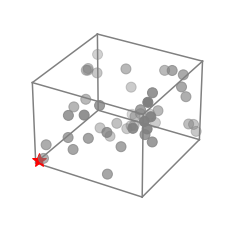

In [11]:
# Generate random particles
particles = genRandomParticles(natoms, system_scale)

# Instantiate
box = Box(np.array([0.0, 0.0, 0.0]), np.array([system_scale, system_scale, system_scale]))
pbc = PeriodicBoundaryCondition(box)
pbc.apply(particles)

lj_potential = LJPotential(box, pbc, epsilon, sigma, cutoff='soft')

times, positions, velocities = evolution(particles, box, pbc, lj_potential, dt, T, algo='leapfrog', visualize=True)